In [36]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn, sigmoid
from torch import optim
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader, random_split

In [37]:
this_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
class HDDataset(Dataset):
    
    def __init__(self, path):
        self.dataset = torch.tensor(pd.read_csv(path).values)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx][:-1], self.dataset[idx][-1]

In [39]:
class HDNNet(nn.Module):
    
    def __init__(self, n_features):
        super().__init__()
        self.n_features = n_features
        
        self.fc1 = nn.Linear(self.n_features, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, inp):
        out = nnf.relu(self.fc1(inp))
        out = nnf.relu(self.fc2(out))
        out = sigmoid(self.fc3(out))
        
        return out

In [40]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot):
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        for example, label in train_loader:
            example = example.to(this_device)
            label = label.to(this_device).unsqueeze(1)
            output = model(example.float())
            
            loss = loss_fn(output, label.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            for loader, accuracy in [(train_loader, train_accuracy), (test_loader, test_accuracy)]:
                correct = 0
                total = 0
                
                for examples, labels in loader:
                    examples = examples.to(device=this_device)
                    labels = labels.to(device=this_device).view(-1, 1)
                    
                    output = model(examples.float())
                    prediction = torch.round(output)
                    
                    total += labels.shape[0]
                    correct += (prediction == labels).sum()
                    
                accuracy[epoch] = correct/total
                
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}\n",
                  f"Train Accuracy: {train_accuracy[epoch]}\n",
                  f"Test Accuracy: {test_accuracy[epoch]}")
    
    if print_plot:
        epochs = range(n_epochs)
        
        plt.plot(epochs, train_accuracy, 'g', label="Training accuracy")
        plt.plot(epochs, test_accuracy, 'b', label="Test accuracy")
        plt.title("Training and Test accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

In [41]:
data = HDDataset(r"../../data/heart.csv")

n_samples = len(data)
n_test = int(0.2*n_samples)

train_set, test_set = random_split(data, [n_samples - n_test, n_test])

train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)

Epoch 10
 Train Accuracy: 0.5720164775848389
 Test Accuracy: 0.6000000238418579
Epoch 20
 Train Accuracy: 0.6419752836227417
 Test Accuracy: 0.6333333253860474
Epoch 30
 Train Accuracy: 0.6666666865348816
 Test Accuracy: 0.6499999761581421
Epoch 40
 Train Accuracy: 0.7119341492652893
 Test Accuracy: 0.6499999761581421
Epoch 50
 Train Accuracy: 0.7366254925727844
 Test Accuracy: 0.6833333373069763
Epoch 60
 Train Accuracy: 0.7654321193695068
 Test Accuracy: 0.7166666388511658
Epoch 70
 Train Accuracy: 0.7777777910232544
 Test Accuracy: 0.7666666507720947
Epoch 80
 Train Accuracy: 0.8024691343307495
 Test Accuracy: 0.7666666507720947
Epoch 90
 Train Accuracy: 0.806584358215332
 Test Accuracy: 0.8166666626930237
Epoch 100
 Train Accuracy: 0.8148148059844971
 Test Accuracy: 0.8666666746139526
Epoch 110
 Train Accuracy: 0.8312757015228271
 Test Accuracy: 0.8833333253860474
Epoch 120
 Train Accuracy: 0.8271604776382446
 Test Accuracy: 0.8500000238418579
Epoch 130
 Train Accuracy: 0.843621373

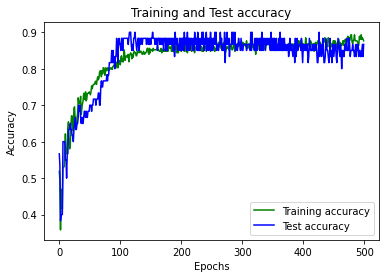

In [42]:
learning_rate = 0.01
model = HDNNet(len(data[0][0])).to(this_device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
training_loop(n_epochs=500, 
              optimizer=optimizer, 
              model=model, 
              loss_fn=loss_fn, 
              train_loader=train_loader, 
              test_loader=test_loader,
              print_plot=True)